In [539]:
import csv
from pathlib import Path
import pandas as pd
from pandas import DataFrame
import os
from dotenv import load_dotenv
from datetime import datetime
from datetime import date
from datetime import timedelta
import requests
import json

import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
import panel as pn
from panel.interact import interact
from panel import widgets
import numpy as np

from scipy.optimize import minimize

%matplotlib inline

# Initialize the Panel Extensions (for Plotly)
pn.extension('plotly')

# Input Portfolio
Read in the input portfolio CSV file and output a portfolio dataframe
* Inputs:
    * Portfolio CSV file
    * Format: Ticker, Transaction (B=buy, S=Sell), Date, Transaction Price, Number of Shares
    * Assumptions: Date unsorted, no '$' sign, no commas
* Outputs:
    * Portfolio database
    * Format: Ticker, Transaction (B=buy, S=Sell), Date, Transaction Price, Number of Shares, Transaction Cost
    * Database sorted by ascending date

In [7]:
# Set the path for the CSV file
input_file_path = Path("TestPortfolio.csv")

In [8]:
#Create empty list to store row data from CSV
portfolio_transactions = []

In [9]:
#Open the CSV file; read in row data; calculate transaction cost per transacation
with open(input_file_path, 'r') as csvfile:
    #Set reader object
    csvreader = csv.reader(csvfile, delimiter = ',')
 
    #Read the header
    csv_header = next(csvreader)
    
    #Create new column
    csv_header.append("Transaction Cost")
    portfolio_transactions.append(csv_header)

    #Iterate through the data 
    for row in csvreader:
        #Calculate transaction cost
        cost = float(row[3]) * float(row[4])
        
        #Append transaction cost to list
        row.append(cost)
        portfolio_transactions.append(row)

In [10]:
#Convert transaction list to dataframe
portfolio_df = pd.DataFrame(portfolio_transactions, columns=['Ticker', 'Transaction', 'Date', 'Transaction Price', 'Number of shares', 'Transaction Cost'])
#Drop first row (duplicate header)
portfolio_df=portfolio_df.drop(portfolio_df.index[0])
portfolio_df

,Ticker,Transaction,Date,Transaction Price,Number of shares,Transaction Cost
1,AAPL,B,3/5/12,77.8,100,7780
2,AAPL,B,4/1/13,60.57,100,6057
3,TSLA,B,9/23/13,189.9,100,18990
4,TSLA,S,11/18/13,122.38,75,9178.5
5,TSLA,B,5/9/16,208,30,6240
6,GOOG,B,8/7/17,915.39,10,9153.9
7,AAPL,S,3/16/20,240,50,12000


In [11]:
#Convert Date to datetime and set as index
portfolio_df['Date']=pd.to_datetime(portfolio_df['Date'])
portfolio_df.set_index(['Date'], inplace=True)
portfolio_df

,Ticker,Transaction,Transaction Price,Number of shares,Transaction Cost
Date,,,,,
2012-03-05,AAPL,B,77.8,100,7780
2013-04-01,AAPL,B,60.57,100,6057
2013-09-23,TSLA,B,189.9,100,18990
2013-11-18,TSLA,S,122.38,75,9178.5
2016-05-09,TSLA,B,208,30,6240
2017-08-07,GOOG,B,915.39,10,9153.9
2020-03-16,AAPL,S,240,50,12000


In [12]:
# Sort dataframe in ascending order
portfolio_df.sort_index(inplace=True)
portfolio_df

,Ticker,Transaction,Transaction Price,Number of shares,Transaction Cost
Date,,,,,
2012-03-05,AAPL,B,77.8,100,7780
2013-04-01,AAPL,B,60.57,100,6057
2013-09-23,TSLA,B,189.9,100,18990
2013-11-18,TSLA,S,122.38,75,9178.5
2016-05-09,TSLA,B,208,30,6240
2017-08-07,GOOG,B,915.39,10,9153.9
2020-03-16,AAPL,S,240,50,12000


# Pull Stock Data
Using the portfolio database, determine the number of unique stocks and pull the stock history.
* Inputs:
    * Portfolio database (portfolio_df)
* Outputs:
    * Ticker Stat database (ticker_stats_df) (Tickers as Rows)
    * Transposed Ticker Stat Database (ticker_stats_df_T) (Tickers as Columns)
    * Dailiy Closing Price database (closing_df)

In [13]:
# Set environment variables from the .env file
# rel_path = Path('../../Python') / '.env'
# load_dotenv(rel_path)
load_dotenv("/Users/heenaroy/Desktop/.env")

True

In [14]:
# Grab API Key for https://financialmodelingprep.com
stock_key = os.getenv("FINANCIAL_MODEL_KEY")

In [15]:
# Create empty list for stock tickers
stock_list=[]

In [16]:
# Determine unique stocks
group=portfolio_df.groupby('Ticker')
# Store unique stocks to stock list
group.groups.keys()
stock_list=list(group.groups)
stock_list

['AAPL', 'GOOG', 'TSLA']

In [17]:
#Create new dataframe resetting date index
portfolio2_df=portfolio_df.reset_index()
portfolio2_df

,Date,Ticker,Transaction,Transaction Price,Number of shares,Transaction Cost
0,2012-03-05,AAPL,B,77.8,100,7780
1,2013-04-01,AAPL,B,60.57,100,6057
2,2013-09-23,TSLA,B,189.9,100,18990
3,2013-11-18,TSLA,S,122.38,75,9178.5
4,2016-05-09,TSLA,B,208,30,6240
5,2017-08-07,GOOG,B,915.39,10,9153.9
6,2020-03-16,AAPL,S,240,50,12000


In [18]:
#Find the min dates per tikcer
min_stock_dates=portfolio2_df.groupby('Ticker').min()
min_stock_dates

,Date,Transaction,Transaction Price,Number of shares,Transaction Cost
Ticker,,,,,
AAPL,2012-03-05,B,240,100,6057.0
GOOG,2017-08-07,B,915.39,10,9153.9
TSLA,2013-09-23,B,122.38,100,6240.0


In [19]:
#Store yesterday's date
yesterday = date.today() - timedelta(days=1)
yesterday = yesterday.strftime("%Y-%m-%d")
yesterday

'2020-06-17'

In [20]:
#Define Main Loop Variables
stock_dict={}            # Create dictionary to store stock data
count=0                  # Create counter as index for looping through stock list

#For each ticker in the stock list, pull the stock data
for ticker in stock_list:
    #Define new dictionary key set per ticker
    stock_dict[ticker]={
        'PE Ratio'            : 0,
        'Profit Margin'       : 0,
        'Cash'                : 0,
        'Beta'                : 0,
        'Last Dividend'       : 0,
        'Industry'            : 0,
        'Sector'              : 0,
        'Daily Closing Price' : 0,
        }
    
######
    #Get Beta, Last Div, Industry and Sector
    url = f"https://financialmodelingprep.com/api/v3/profile/{ticker}?apikey={stock_key}"
    requests.get(url).content
    parsed = json.loads(requests.get(url).content)
    
    #Store stock data in dictionary
    stock_dict[ticker]['Beta']=parsed[0]['beta']
    stock_dict[ticker]['Last Dividend']=parsed[0]['lastDiv']
    stock_dict[ticker]['Industry']=parsed[0]['industry']
    stock_dict[ticker]['Sector']=parsed[0]['sector']
    

######
    # Grab PE Ratio
    url = f"https://financialmodelingprep.com/api/v3/key-metrics/{ticker}?apikey={stock_key}"
    requests.get(url).content
    parsed = json.loads(requests.get(url).content)
    
    # Store PE Ratio in dictionary
    stock_dict[ticker]['PE Ratio']=parsed[0]['peRatio']
    
    
######    
    # Grab Profit Margin
    url = f"https://financialmodelingprep.com/api/v3/ratios/{ticker}?apikey={stock_key}"
    requests.get(url).content
    parsed = json.loads(requests.get(url).content)
    
    # Store Profit Margin in dictionary
    stock_dict[ticker]['Profit Margin']=parsed[0]['netProfitMargin']
    
   
###### 
    # Grab Cash
    url = f"https://financialmodelingprep.com/api/v3/balance-sheet-statement/{ticker}?apikey={stock_key}"
    requests.get(url).content
    parsed = json.loads(requests.get(url).content)
    
    # Store Profit Margin in dictionary
    stock_dict[ticker]['Cash']=parsed[0]['cashAndCashEquivalents']

     
######
    #Grab the first purchase date for current ticker
    datetime_obj=datetime.strptime(str(min_stock_dates['Date'][ticker]),"%Y-%m-%d %H:%M:%S")
    date_obj=datetime_obj.date()
    first_purchase_date=str(date_obj)
    
    # Grab the Daily Closing Prices between the first purchase date and yesterday
    url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?from={first_purchase_date}&to={yesterday}&apikey={stock_key}"
    requests.get(url).content
    parsed = json.loads(requests.get(url).content)
 
    ### Daily Stock Pull Variables
    count2=0                 # Create counter as index for looping through dictionary of stock data    
    daily_dict={}            # Create empty dictionary to store daily stock data before appending to daily_list_of_dict
    daily_list_of_dict = []  # Create empty list to store dictionary info from daily_dict before storing to stock_dict

    # Loop through historical data and grab daily closing date and price
    for i in parsed['historical']:
        daily_dict['Date'] = parsed['historical'][count2]['date']
        daily_dict['Price'] = parsed['historical'][count2]['close']
        daily_list_of_dict.append(daily_dict.copy())
        count2+=1

    #Store historical stock data to stock_dict dictionary
    stock_dict[ticker]['Daily Closing Price']=daily_list_of_dict
    
    
    #increment counter
    count+=1 

In [21]:
#Copy stock_dict so that main loop above doesn't have to be run multiple times
stock_dict_copy = stock_dict
stock_dict_copy

{'AAPL': {'PE Ratio': 20.81351450883162,
  'Profit Margin': 0.21238094505984456,
  'Cash': 48844000000,
  'Beta': 1.228499,
  'Last Dividend': 3.08,
  'Industry': 'Consumer Electronics',
  'Sector': 'Technology',
  'Daily Closing Price': [{'Date': '2020-06-17', 'Price': 351.59},
   {'Date': '2020-06-16', 'Price': 352.08},
   {'Date': '2020-06-15', 'Price': 342.99},
   {'Date': '2020-06-12', 'Price': 338.8},
   {'Date': '2020-06-11', 'Price': 335.9},
   {'Date': '2020-06-10', 'Price': 352.84},
   {'Date': '2020-06-09', 'Price': 343.99},
   {'Date': '2020-06-08', 'Price': 333.46},
   {'Date': '2020-06-05', 'Price': 331.5},
   {'Date': '2020-06-04', 'Price': 322.32},
   {'Date': '2020-06-03', 'Price': 325.12},
   {'Date': '2020-06-02', 'Price': 323.34},
   {'Date': '2020-06-01', 'Price': 321.85},
   {'Date': '2020-05-29', 'Price': 317.94},
   {'Date': '2020-05-28', 'Price': 318.25},
   {'Date': '2020-05-27', 'Price': 318.11},
   {'Date': '2020-05-26', 'Price': 316.73},
   {'Date': '2020-0

In [22]:
# Create DataFrame showing Beta, P/E Ratio, Profit Margin, 
# Cash, and current Dividends per ticker
ticker_stats_df=DataFrame(stock_dict_copy)
ticker_stats_df.drop('Daily Closing Price', inplace=True)
ticker_stats_df

,AAPL,GOOG,TSLA
Beta,1.2285,1.02276,0.580101
Cash,48844000000,18498000000,6268000000
Industry,Consumer Electronics,Internet Content & Information,Auto Manufacturers
Last Dividend,3.08,0,0
PE Ratio,20.8135,14.6956,-131.582
Profit Margin,0.212381,0.212181,-0.035072
Sector,Technology,Communication Services,Consumer Cyclical


In [23]:
# Create a transpose of ticker_stats_df
ticker_stats_df_T=ticker_stats_df.T
ticker_stats_df_T=ticker_stats_df_T[['PE Ratio', 'Profit Margin', 'Cash', 'Beta', 'Last Dividend', 'Industry', 'Sector']]
ticker_stats_df_T

,PE Ratio,Profit Margin,Cash,Beta,Last Dividend,Industry,Sector
AAPL,20.8135,0.212381,48844000000,1.2285,3.08,Consumer Electronics,Technology
GOOG,14.6956,0.212181,18498000000,1.02276,0,Internet Content & Information,Communication Services
TSLA,-131.582,-0.035072,6268000000,0.580101,0,Auto Manufacturers,Consumer Cyclical


# Closing Data

In [25]:
# Create DataFrame showing Daily Closing Price per ticker

daily_closing_df=DataFrame(stock_dict_copy)
daily_closing_df.drop(['Beta', 'Cash', 'Industry', 'Last Dividend', 'PE Ratio', 'Profit Margin', 'Sector'], inplace=True)

daily_closing_df

,AAPL,GOOG,TSLA
Daily Closing Price,"[{'Date': '2020-06-17', 'Price': 351.59}, {'Da...","[{'Date': '2020-06-17', 'Price': 1451.12}, {'D...","[{'Date': '2020-06-17', 'Price': 991.79}, {'Da..."


In [26]:
# Create DF for AAPL

aapl_df = pd.DataFrame(daily_closing_df['AAPL'][0])
#aapl_df.rename(columns={'Date' : 'AAPL Closing Date', 'Price' : 'AAPL Closing Price'}, inplace=True)
aapl_df.rename(columns={'Price' : 'AAPL Closing Price'}, inplace=True)
aapl_df.head()

,Date,AAPL Closing Price
0,2020-06-17,351.59
1,2020-06-16,352.08
2,2020-06-15,342.99
3,2020-06-12,338.80
4,2020-06-11,335.90


In [27]:
# Create DF for GOOG

goog_df = pd.DataFrame(daily_closing_df['GOOG'][0])
#goog_df.rename(columns={'Date' : 'GOOG Closing Date', 'Price' : 'GOOG Closing Price'}, inplace=True)
goog_df.rename(columns={'Price' : 'GOOG Closing Price'}, inplace=True)
goog_df.head()

,Date,GOOG Closing Price
0,2020-06-17,1451.12
1,2020-06-16,1442.72
2,2020-06-15,1419.85
3,2020-06-12,1413.18
4,2020-06-11,1403.84


In [28]:
# Create DF for TSLA

tsla_df = pd.DataFrame(daily_closing_df['TSLA'][0])
#tsla_df.rename(columns={'Date' : 'TSLA Closing Date', 'Price' : 'TSLA Closing Price'}, inplace=True)
tsla_df.rename(columns={'Price' : 'TSLA Closing Price'}, inplace=True)
tsla_df.head()

,Date,TSLA Closing Price
0,2020-06-17,991.79
1,2020-06-16,982.13
2,2020-06-15,990.90
3,2020-06-12,935.28
4,2020-06-11,972.84


In [29]:
# Create DataFrame showing Daily Closing Price per ticker

closing_df = aapl_df.set_index('Date').join(goog_df.set_index('Date')).join(tsla_df.set_index('Date'))
closing_df.head()

,AAPL Closing Price,GOOG Closing Price,TSLA Closing Price
Date,,,
2020-06-17,351.59,1451.12,991.79
2020-06-16,352.08,1442.72,982.13
2020-06-15,342.99,1419.85,990.90
2020-06-12,338.80,1413.18,935.28
2020-06-11,335.90,1403.84,972.84


# Insert Alex's Code

In [30]:
# Convert daily closing price data (stock_dict_copy['Daily Closing Price'])
# into a new dataframe (closing_price_df) with only Date, Ticker, and Close columns
date=[]
price=[]
stock_name=[]

for stock in stock_dict_copy:
    for d in stock_dict_copy[stock]['Daily Closing Price']:
        stock_name.append(stock)
        date.append(datetime.strptime(d['Date'],'%Y-%m-%d'))
        price.append(d['Price'])
        
closing_price_df= pd.DataFrame(list(zip(date, stock_name, price)), columns=['Date', 'Ticker', 'Close'])
closing_price_df

,Date,Ticker,Close
0,2020-06-17,AAPL,351.59
1,2020-06-16,AAPL,352.08
2,2020-06-15,AAPL,342.99
3,2020-06-12,AAPL,338.80
4,2020-06-11,AAPL,335.90
5,2020-06-10,AAPL,352.84
6,2020-06-09,AAPL,343.99
7,2020-06-08,AAPL,333.46
8,2020-06-05,AAPL,331.50
9,2020-06-04,AAPL,322.32


In [31]:
closing_price_df=closing_price_df.sort_values('Date')
closing_price_df

,Date,Ticker,Close
2085,2012-03-05,AAPL,76.17
2084,2012-03-06,AAPL,75.75
2083,2012-03-07,AAPL,75.81
2082,2012-03-08,AAPL,77.43
2081,2012-03-09,AAPL,77.88
2080,2012-03-12,AAPL,78.86
2079,2012-03-13,AAPL,81.16
2078,2012-03-14,AAPL,84.23
2077,2012-03-15,AAPL,83.65
2076,2012-03-16,AAPL,83.65


In [32]:
#Merge the input portfolio dataframe to the closing price dataframe
portfolio3_df = pd.merge(portfolio_df, closing_price_df, how='right', left_on=['Date', 'Ticker'], right_on=['Date', 'Ticker'])
portfolio3_df

,Date,Ticker,Transaction,Transaction Price,Number of shares,Transaction Cost,Close
0,2012-03-05,AAPL,B,77.8,100,7780,76.17
1,2013-04-01,AAPL,B,60.57,100,6057,61.27
2,2013-09-23,TSLA,B,189.9,100,18990,181.11
3,2013-11-18,TSLA,S,122.38,75,9178.5,121.58
4,2016-05-09,TSLA,B,208,30,6240,208.92
5,2017-08-07,GOOG,B,915.39,10,9153.9,929.36
6,2020-03-16,AAPL,S,240,50,12000,242.21
7,2012-03-06,AAPL,NaN,NaN,NaN,NaN,75.75
8,2012-03-07,AAPL,NaN,NaN,NaN,NaN,75.81
9,2012-03-08,AAPL,NaN,NaN,NaN,NaN,77.43


In [33]:
portfolio3_df=portfolio3_df.sort_values('Date')
portfolio3_df=portfolio3_df.reset_index(drop=True)
portfolio3_df

,Date,Ticker,Transaction,Transaction Price,Number of shares,Transaction Cost,Close
0,2012-03-05,AAPL,B,77.8,100,7780,76.17
1,2012-03-06,AAPL,NaN,NaN,NaN,NaN,75.75
2,2012-03-07,AAPL,NaN,NaN,NaN,NaN,75.81
3,2012-03-08,AAPL,NaN,NaN,NaN,NaN,77.43
4,2012-03-09,AAPL,NaN,NaN,NaN,NaN,77.88
5,2012-03-12,AAPL,NaN,NaN,NaN,NaN,78.86
6,2012-03-13,AAPL,NaN,NaN,NaN,NaN,81.16
7,2012-03-14,AAPL,NaN,NaN,NaN,NaN,84.23
8,2012-03-15,AAPL,NaN,NaN,NaN,NaN,83.65
9,2012-03-16,AAPL,NaN,NaN,NaN,NaN,83.65


In [34]:
portfolio3_df['Number of shares']=portfolio3_df['Number of shares'].fillna(0)
portfolio3_df

,Date,Ticker,Transaction,Transaction Price,Number of shares,Transaction Cost,Close
0,2012-03-05,AAPL,B,77.8,100,7780,76.17
1,2012-03-06,AAPL,NaN,NaN,0,NaN,75.75
2,2012-03-07,AAPL,NaN,NaN,0,NaN,75.81
3,2012-03-08,AAPL,NaN,NaN,0,NaN,77.43
4,2012-03-09,AAPL,NaN,NaN,0,NaN,77.88
5,2012-03-12,AAPL,NaN,NaN,0,NaN,78.86
6,2012-03-13,AAPL,NaN,NaN,0,NaN,81.16
7,2012-03-14,AAPL,NaN,NaN,0,NaN,84.23
8,2012-03-15,AAPL,NaN,NaN,0,NaN,83.65
9,2012-03-16,AAPL,NaN,NaN,0,NaN,83.65


In [35]:
# Convert Number of shares and Transaction Price to float
portfolio3_df['Number of shares']=portfolio3_df['Number of shares'].astype(float)
portfolio3_df['Transaction Price']=portfolio3_df['Transaction Price'].astype(float)

In [36]:
# Calculate total number of shares
portfolio3_df['Net Shares'] = portfolio3_df.apply(lambda row: row['Number of shares'] if row.Transaction == "B" else row['Number of shares'] * -1, axis=1)
portfolio3_df['Cumulative Shares'] = portfolio3_df[['Net Shares','Ticker']].groupby('Ticker').cumsum()
# portfolio3_df.drop('Net Shares', inplace=True)
portfolio3_df

,Date,Ticker,Transaction,Transaction Price,Number of shares,Transaction Cost,Close,Net Shares,Cumulative Shares
0,2012-03-05,AAPL,B,77.8,100.0,7780,76.17,100.0,100.0
1,2012-03-06,AAPL,NaN,NaN,0.0,NaN,75.75,-0.0,100.0
2,2012-03-07,AAPL,NaN,NaN,0.0,NaN,75.81,-0.0,100.0
3,2012-03-08,AAPL,NaN,NaN,0.0,NaN,77.43,-0.0,100.0
4,2012-03-09,AAPL,NaN,NaN,0.0,NaN,77.88,-0.0,100.0
5,2012-03-12,AAPL,NaN,NaN,0.0,NaN,78.86,-0.0,100.0
6,2012-03-13,AAPL,NaN,NaN,0.0,NaN,81.16,-0.0,100.0
7,2012-03-14,AAPL,NaN,NaN,0.0,NaN,84.23,-0.0,100.0
8,2012-03-15,AAPL,NaN,NaN,0.0,NaN,83.65,-0.0,100.0
9,2012-03-16,AAPL,NaN,NaN,0.0,NaN,83.65,-0.0,100.0


In [461]:
# Create function to calculate Avg Cost per Share (By Individual Ticker DF)

def avg_price(df):
    first_time=0
    avg_price_list=[]
    tran=len(df)

    for i in range(tran):
        if first_time == 0:
            avg_price = df['Transaction Price'][i]
            prev_trans_price = df['Transaction Price'][i]
            prev_trans_cost = df['Transaction Cost'][i]
            prev_trans_shares = df['Number of shares'][i]
            first_time=1
        else:
            if df['Transaction'][i] == "B":
                avg_price = (prev_trans_price * prev_trans_shares + df['Transaction Cost'][i])/(df['Cumulative Shares'][i])
#                 avg_price = (prev_trans_cost + df['Transaction Cost'][i])/(df['Cummulative Shares'][i])
                prev_trans_cost = prev_trans_cost + df['Transaction Cost'][i]
            elif df['Transaction'][i] == "S":
                avg_price = avg_price
                prev_trans_price = prev_trans_price
                prev_trans_cost = prev_trans_cost
                prev_trans_shares = prev_trans_shares - df['Number of shares'][i]
            else:
                avg_price = avg_price

        avg_price_list.append(avg_price)

    return avg_price_list

In [462]:
# Create DF for AAPL

aapl3_df = portfolio3_df[portfolio3_df['Ticker']=='AAPL']
aapl3_df=aapl3_df.reset_index(drop=True)

# Run function to create Avg Cost per Share for AAPL

aapl3_df['Avg Price per Share']=pd.DataFrame(avg_price(aapl3_df))

aapl3_df

,Date,Ticker,Transaction,Transaction Price,Number of shares,Transaction Cost,Close,Net Shares,Cumulative Shares,Avg Price per Share
0,2012-03-05,AAPL,B,77.8,100.0,7780,76.17,100.0,100.0,77.800
1,2012-03-06,AAPL,NaN,NaN,0.0,NaN,75.75,-0.0,100.0,77.800
2,2012-03-07,AAPL,NaN,NaN,0.0,NaN,75.81,-0.0,100.0,77.800
3,2012-03-08,AAPL,NaN,NaN,0.0,NaN,77.43,-0.0,100.0,77.800
4,2012-03-09,AAPL,NaN,NaN,0.0,NaN,77.88,-0.0,100.0,77.800
5,2012-03-12,AAPL,NaN,NaN,0.0,NaN,78.86,-0.0,100.0,77.800
6,2012-03-13,AAPL,NaN,NaN,0.0,NaN,81.16,-0.0,100.0,77.800
7,2012-03-14,AAPL,NaN,NaN,0.0,NaN,84.23,-0.0,100.0,77.800
8,2012-03-15,AAPL,NaN,NaN,0.0,NaN,83.65,-0.0,100.0,77.800
9,2012-03-16,AAPL,NaN,NaN,0.0,NaN,83.65,-0.0,100.0,77.800


In [463]:
# Create DF for TSLA

tsla3_df = portfolio3_df[portfolio3_df['Ticker']=='TSLA']
tsla3_df=tsla3_df.reset_index(drop=True)

# Run function to create Avg Cost per Share for TSLA

tsla3_df['Avg Price per Share']=pd.DataFrame(avg_price(tsla3_df))

tsla3_df

,Date,Ticker,Transaction,Transaction Price,Number of shares,Transaction Cost,Close,Net Shares,Cumulative Shares,Avg Price per Share
0,2013-09-23,TSLA,B,189.9,100.0,18990,181.11,100.0,100.0,189.900000
1,2013-09-24,TSLA,NaN,NaN,0.0,NaN,182.33,-0.0,100.0,189.900000
2,2013-09-25,TSLA,NaN,NaN,0.0,NaN,185.24,-0.0,100.0,189.900000
3,2013-09-26,TSLA,NaN,NaN,0.0,NaN,188.64,-0.0,100.0,189.900000
4,2013-09-27,TSLA,NaN,NaN,0.0,NaN,190.90,-0.0,100.0,189.900000
5,2013-09-30,TSLA,NaN,NaN,0.0,NaN,193.37,-0.0,100.0,189.900000
6,2013-10-01,TSLA,NaN,NaN,0.0,NaN,193.00,-0.0,100.0,189.900000
7,2013-10-02,TSLA,NaN,NaN,0.0,NaN,180.95,-0.0,100.0,189.900000
8,2013-10-03,TSLA,NaN,NaN,0.0,NaN,173.31,-0.0,100.0,189.900000
9,2013-10-04,TSLA,NaN,NaN,0.0,NaN,180.98,-0.0,100.0,189.900000


In [464]:
# Create DF for GOOG

goog3_df = portfolio3_df[portfolio3_df['Ticker']=='GOOG']
goog3_df=goog3_df.reset_index(drop=True)

# Run function to create Avg Cost per Share for GOOG

goog3_df['Avg Price per Share']=pd.DataFrame(avg_price(goog3_df))

goog3_df

,Date,Ticker,Transaction,Transaction Price,Number of shares,Transaction Cost,Close,Net Shares,Cumulative Shares,Avg Price per Share
0,2017-08-07,GOOG,B,915.39,10.0,9153.9,929.36,10.0,10.0,915.39
1,2017-08-08,GOOG,NaN,NaN,0.0,NaN,926.79,-0.0,10.0,915.39
2,2017-08-09,GOOG,NaN,NaN,0.0,NaN,922.90,-0.0,10.0,915.39
3,2017-08-10,GOOG,NaN,NaN,0.0,NaN,907.24,-0.0,10.0,915.39
4,2017-08-11,GOOG,NaN,NaN,0.0,NaN,914.39,-0.0,10.0,915.39
5,2017-08-14,GOOG,NaN,NaN,0.0,NaN,922.67,-0.0,10.0,915.39
6,2017-08-15,GOOG,NaN,NaN,0.0,NaN,922.22,-0.0,10.0,915.39
7,2017-08-16,GOOG,NaN,NaN,0.0,NaN,926.96,-0.0,10.0,915.39
8,2017-08-17,GOOG,NaN,NaN,0.0,NaN,910.98,-0.0,10.0,915.39
9,2017-08-18,GOOG,NaN,NaN,0.0,NaN,910.67,-0.0,10.0,915.39


In [465]:
# Merge all 3 tickers to new dataframe

portfolio4_df=pd.concat([aapl3_df, goog3_df, tsla3_df],ignore_index=True)
portfolio4_df=portfolio4_df.sort_values('Date')
portfolio4_df=portfolio4_df.reset_index(drop=True)

portfolio4_df

,Date,Ticker,Transaction,Transaction Price,Number of shares,Transaction Cost,Close,Net Shares,Cumulative Shares,Avg Price per Share
0,2012-03-05,AAPL,B,77.8,100.0,7780,76.17,100.0,100.0,77.800000
1,2012-03-06,AAPL,NaN,NaN,0.0,NaN,75.75,-0.0,100.0,77.800000
2,2012-03-07,AAPL,NaN,NaN,0.0,NaN,75.81,-0.0,100.0,77.800000
3,2012-03-08,AAPL,NaN,NaN,0.0,NaN,77.43,-0.0,100.0,77.800000
4,2012-03-09,AAPL,NaN,NaN,0.0,NaN,77.88,-0.0,100.0,77.800000
5,2012-03-12,AAPL,NaN,NaN,0.0,NaN,78.86,-0.0,100.0,77.800000
6,2012-03-13,AAPL,NaN,NaN,0.0,NaN,81.16,-0.0,100.0,77.800000
7,2012-03-14,AAPL,NaN,NaN,0.0,NaN,84.23,-0.0,100.0,77.800000
8,2012-03-15,AAPL,NaN,NaN,0.0,NaN,83.65,-0.0,100.0,77.800000
9,2012-03-16,AAPL,NaN,NaN,0.0,NaN,83.65,-0.0,100.0,77.800000


In [467]:
# Calculate Cumulative Contribution Column based on Cumulative Shares and Avg Price per Share

portfolio4_df["Cumulative Contributions"] = portfolio4_df["Cumulative Shares"] * portfolio4_df["Avg Price per Share"]

# Calculate Daily Balance Column based on Cumulative Shares and Daily Closing Price

portfolio4_df["Daily Balance"] = portfolio4_df["Cumulative Shares"] * portfolio4_df["Close"]

# Calculate Unrealized Gains (Losses) based on Daily Balance and Cumulative Contributions

portfolio4_df["Unrealized Gains(Losses)"] = portfolio4_df["Daily Balance"] - portfolio4_df["Cumulative Contributions"]

portfolio4_df

,Date,Ticker,Transaction,Transaction Price,Number of shares,Transaction Cost,Close,Net Shares,Cumulative Shares,Avg Price per Share,Cumulative Contributions,Daily Balance,Unrealized Gains(Losses)
0,2012-03-05,AAPL,B,77.8,100.0,7780,76.17,100.0,100.0,77.800000,7780.00,7617.00,-163.00
1,2012-03-06,AAPL,NaN,NaN,0.0,NaN,75.75,-0.0,100.0,77.800000,7780.00,7575.00,-205.00
2,2012-03-07,AAPL,NaN,NaN,0.0,NaN,75.81,-0.0,100.0,77.800000,7780.00,7581.00,-199.00
3,2012-03-08,AAPL,NaN,NaN,0.0,NaN,77.43,-0.0,100.0,77.800000,7780.00,7743.00,-37.00
4,2012-03-09,AAPL,NaN,NaN,0.0,NaN,77.88,-0.0,100.0,77.800000,7780.00,7788.00,8.00
5,2012-03-12,AAPL,NaN,NaN,0.0,NaN,78.86,-0.0,100.0,77.800000,7780.00,7886.00,106.00
6,2012-03-13,AAPL,NaN,NaN,0.0,NaN,81.16,-0.0,100.0,77.800000,7780.00,8116.00,336.00
7,2012-03-14,AAPL,NaN,NaN,0.0,NaN,84.23,-0.0,100.0,77.800000,7780.00,8423.00,643.00
8,2012-03-15,AAPL,NaN,NaN,0.0,NaN,83.65,-0.0,100.0,77.800000,7780.00,8365.00,585.00
9,2012-03-16,AAPL,NaN,NaN,0.0,NaN,83.65,-0.0,100.0,77.800000,7780.00,8365.00,585.00


In [468]:
# Set the path for the S&P 500 csv files

sp500_csv = Path("SP500.csv")

# Read the csv files

sp500_df = pd.read_csv(sp500_csv, index_col="DATE", parse_dates=True, infer_datetime_format=True)
sp500_df.reset_index(inplace=True)
# sp500_df.rename(columns={"DATE": "Date"}, inplace=True)
sp500_df


,DATE,SP500
0,2013-03-05,1539.79
1,2013-03-06,1541.46
2,2013-03-07,1544.26
3,2013-03-08,1551.18
4,2013-03-11,1556.22
5,2013-03-12,1552.48
6,2013-03-13,1554.52
7,2013-03-14,1563.23
8,2013-03-15,1560.70
9,2013-03-18,1552.10


In [471]:
sp500_df["SP500"]=sp500_df["SP500"].astype(float)
sp500_df

,DATE,SP500
0,2013-03-05,1539.79
1,2013-03-06,1541.46
2,2013-03-07,1544.26
3,2013-03-08,1551.18
4,2013-03-11,1556.22
5,2013-03-12,1552.48
6,2013-03-13,1554.52
7,2013-03-14,1563.23
8,2013-03-15,1560.70
9,2013-03-18,1552.10


In [472]:
sp500_plot=sp500_df.hvplot(x="DATE", y="SP500")
sp500_plot

:Curve   [DATE]   (SP500)

In [473]:
portfolio_df_returns = portfolio4_df.drop(columns=['Transaction','Transaction Price', 'Number of shares', 'Transaction Cost', 'Close', 'Net Shares', 'Cumulative Shares'])
portfolio_df_returns.drop(columns=['Avg Price per Share','Cumulative Contributions', 'Unrealized Gains(Losses)'], inplace=True)
# portfolio_df_returns.set_index(["Date"], inplace=True)
portfolio_df_returns

,Date,Ticker,Daily Balance
0,2012-03-05,AAPL,7617.00
1,2012-03-06,AAPL,7575.00
2,2012-03-07,AAPL,7581.00
3,2012-03-08,AAPL,7743.00
4,2012-03-09,AAPL,7788.00
5,2012-03-12,AAPL,7886.00
6,2012-03-13,AAPL,8116.00
7,2012-03-14,AAPL,8423.00
8,2012-03-15,AAPL,8365.00
9,2012-03-16,AAPL,8365.00


In [474]:
portfolio_df_returns=portfolio_df_returns.pivot(index="Date", columns="Ticker", values="Daily Balance")
portfolio_df_returns.reset_index(inplace=True)
portfolio_df_returns=portfolio_df_returns.fillna(0)


portfolio_df_returns

Ticker,Date,AAPL,GOOG,TSLA
0,2012-03-05,7617.0,0.0,0.00
1,2012-03-06,7575.0,0.0,0.00
2,2012-03-07,7581.0,0.0,0.00
3,2012-03-08,7743.0,0.0,0.00
4,2012-03-09,7788.0,0.0,0.00
5,2012-03-12,7886.0,0.0,0.00
6,2012-03-13,8116.0,0.0,0.00
7,2012-03-14,8423.0,0.0,0.00
8,2012-03-15,8365.0,0.0,0.00
9,2012-03-16,8365.0,0.0,0.00


In [476]:

portfolio_df_returns["Total Portfolio"]=portfolio_df_returns["AAPL"]+portfolio_df_returns["GOOG"]+portfolio_df_returns["TSLA"]

# portfolio_df_returns=portfolio_df_returns.droplevel([1], axis=1)
# portfolio_df_returns.fillna(0)
# portfolio_df_returns.reset_index(inplace=True)
portfolio_df_returns

Ticker,Date,AAPL,GOOG,TSLA,Total Portfolio
0,2012-03-05,7617.0,0.0,0.00,7617.00
1,2012-03-06,7575.0,0.0,0.00,7575.00
2,2012-03-07,7581.0,0.0,0.00,7581.00
3,2012-03-08,7743.0,0.0,0.00,7743.00
4,2012-03-09,7788.0,0.0,0.00,7788.00
5,2012-03-12,7886.0,0.0,0.00,7886.00
6,2012-03-13,8116.0,0.0,0.00,8116.00
7,2012-03-14,8423.0,0.0,0.00,8423.00
8,2012-03-15,8365.0,0.0,0.00,8365.00
9,2012-03-16,8365.0,0.0,0.00,8365.00


In [477]:
portfolio_df_returns["S&P 500"]=sp500_df["SP500"]

portfolio_df_returns.set_index(["Date"],inplace=True)

portfolio_df_returns

Ticker,AAPL,GOOG,TSLA,Total Portfolio,S&P 500
Date,,,,,
2012-03-05,7617.0,0.0,0.00,7617.00,1539.79
2012-03-06,7575.0,0.0,0.00,7575.00,1541.46
2012-03-07,7581.0,0.0,0.00,7581.00,1544.26
2012-03-08,7743.0,0.0,0.00,7743.00,1551.18
2012-03-09,7788.0,0.0,0.00,7788.00,1556.22
2012-03-12,7886.0,0.0,0.00,7886.00,1552.48
2012-03-13,8116.0,0.0,0.00,8116.00,1554.52
2012-03-14,8423.0,0.0,0.00,8423.00,1563.23
2012-03-15,8365.0,0.0,0.00,8365.00,1560.70


In [478]:
portfolio_df_returns2 = pd.DataFrame(portfolio_df_returns.pct_change()).fillna(0)
portfolio_df_returns2

Ticker,AAPL,GOOG,TSLA,Total Portfolio,S&P 500
Date,,,,,
2012-03-05,0.000000,0.000000,0.000000,0.000000,0.000000
2012-03-06,-0.005514,0.000000,0.000000,-0.005514,0.001085
2012-03-07,0.000792,0.000000,0.000000,0.000792,0.001816
2012-03-08,0.021369,0.000000,0.000000,0.021369,0.004481
2012-03-09,0.005812,0.000000,0.000000,0.005812,0.003249
2012-03-12,0.012583,0.000000,0.000000,0.012583,-0.002403
2012-03-13,0.029166,0.000000,0.000000,0.029166,0.001314
2012-03-14,0.037827,0.000000,0.000000,0.037827,0.005603
2012-03-15,-0.006886,0.000000,0.000000,-0.006886,-0.001618


In [479]:
portfolio_df_returns3=portfolio_df_returns.drop(columns=["AAPL", "GOOG", "TSLA"])
portfolio_df_returns3

Ticker,Total Portfolio,S&P 500
Date,,
2012-03-05,7617.00,1539.79
2012-03-06,7575.00,1541.46
2012-03-07,7581.00,1544.26
2012-03-08,7743.00,1551.18
2012-03-09,7788.00,1556.22
2012-03-12,7886.00,1552.48
2012-03-13,8116.00,1554.52
2012-03-14,8423.00,1563.23
2012-03-15,8365.00,1560.70


In [480]:
portfolio_df_returns4=portfolio_df_returns2.drop(columns=["AAPL", "GOOG", "TSLA"])
portfolio_df_returns4

Ticker,Total Portfolio,S&P 500
Date,,
2012-03-05,0.000000,0.000000
2012-03-06,-0.005514,0.001085
2012-03-07,0.000792,0.001816
2012-03-08,0.021369,0.004481
2012-03-09,0.005812,0.003249
2012-03-12,0.012583,-0.002403
2012-03-13,0.029166,0.001314
2012-03-14,0.037827,0.005603
2012-03-15,-0.006886,-0.001618


In [481]:
def returns_plot(df):
    return df.hvplot.line(
        x="Date",
        y="Daily Balance",
        groupby= "Ticker").opts(title="Returns")

returns_plot(portfolio4_df)

:DynamicMap   [Ticker]
   :Curve   [Date]   (Daily Balance)

In [485]:
def pct_change_plot(df):
    return df.hvplot(
        x="Date",
#         y="Returns",
#         groupby= "Ticker"
        ).opts(title="Returns Daily Percent Change")

pct_change_plot(portfolio_df_returns3)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [486]:
# Define last closing price date

max_date=portfolio4_df["Date"].max()

max_date

Timestamp('2020-06-17 00:00:00')

In [487]:
# Create new dataframe with Current Values for Total Shares, Daily Balance, and Cumm Contribution

holdings_df=portfolio4_df[portfolio4_df.Date == max_date]
holdings_df=holdings_df.drop(columns=["Date", "Transaction", "Transaction Price", "Number of shares", "Transaction Cost", "Close", "Net Shares", "Avg Price per Share", "Unrealized Gains(Losses)"]).sort_values("Ticker")

holdings_df

,Ticker,Cumulative Shares,Cumulative Contributions,Daily Balance
4500,AAPL,150.0,10377.75,52738.50
4501,GOOG,10.0,9153.90,14511.20
4502,TSLA,55.0,10987.50,54548.45


In [488]:
# Create new dataframe with Industry & Sector information by Ticker

sector_df=ticker_stats_df_T[["Industry", "Sector"]].reset_index()
sector_df.rename(columns={"index":"Ticker"}, inplace=True)

sector_df

,Ticker,Industry,Sector
0,AAPL,Consumer Electronics,Technology
1,GOOG,Internet Content & Information,Communication Services
2,TSLA,Auto Manufacturers,Consumer Cyclical


In [489]:
# Create new dataframe with Current Values and Industry/Sector information by Ticker

current_industry_holdings = pd.merge(holdings_df, sector_df, on="Ticker")

current_industry_holdings

,Ticker,Cumulative Shares,Cumulative Contributions,Daily Balance,Industry,Sector
0,AAPL,150.0,10377.75,52738.50,Consumer Electronics,Technology
1,GOOG,10.0,9153.90,14511.20,Internet Content & Information,Communication Services
2,TSLA,55.0,10987.50,54548.45,Auto Manufacturers,Consumer Cyclical


In [490]:
# Create Pie Charts for Current Value, Contributions, and Total Shares by Ticker

holdings_contribution_pie=px.pie(current_industry_holdings, values="Cumulative Contributions", names="Ticker", title="Contributions by Stock")
# holdings_shares_pie=px.pie(current_industry_holdings, values="Cumulative Shares", names="Ticker", title="Shares Owned by Stock").update_layout(showlegend=False)
holdings_value_pie=px.pie(current_industry_holdings, values="Daily Balance", names="Ticker", title="Current Value by Stock").update_layout(showlegend=False)


In [491]:
# Create new dataframe for Industry holdings

industry_holdings = current_industry_holdings.groupby("Industry").sum()
industry_holdings.reset_index(inplace=True)

industry_holdings

,Industry,Cumulative Shares,Cumulative Contributions,Daily Balance
0,Auto Manufacturers,55.0,10987.50,54548.45
1,Consumer Electronics,150.0,10377.75,52738.50
2,Internet Content & Information,10.0,9153.90,14511.20


In [492]:
# Create Pie Charts for Current Value, Contributions, and Total Shares by Industry

industry_contribution_pie=px.pie(industry_holdings, values="Cumulative Contributions", names="Industry", title="Contributions by Industry")
# industry_shares_pie=px.pie(industry_holdings, values="Cumulative Shares", names="Industry", title="Shares Owned by Industry").update_layout(showlegend=False)
industry_value_pie=px.pie(industry_holdings, values="Daily Balance", names="Industry", title="Current Value by Industry").update_layout(showlegend=False)


In [493]:
# Create new dataframe for Sector holdings

sector_holdings= current_industry_holdings.groupby("Sector").sum()
sector_holdings.reset_index(inplace=True)

sector_holdings

,Sector,Cumulative Shares,Cumulative Contributions,Daily Balance
0,Communication Services,10.0,9153.90,14511.20
1,Consumer Cyclical,55.0,10987.50,54548.45
2,Technology,150.0,10377.75,52738.50


In [494]:
# Create Pie Charts for Current Value, Contributions, and Total Shares by Sector

sector_contribution_pie=px.pie(sector_holdings, values="Cumulative Contributions", names="Sector", title="Contributions by Sector")
# sector_shares_pie=px.pie(sector_holdings, values="Cumulative Shares", names="Sector", title="Shares Owned by Sector").update_layout(showlegend=False)
sector_value_pie=px.pie(sector_holdings, values="Daily Balance", names="Sector", title="Current Value by Sector").update_layout(showlegend=False)


# Create Ticker Stats Panel
Using the portfolio database, determine the number of unique stocks and pull stock history.
* Inputs:
    * Transposed Ticker Stat Database (ticker_stats_df_T) (Tickers as Columns)
* Outputs:
    * Ticker Stat Panel (stats_panel)

In [498]:
# Define function that will change negative numbers to red text
def color_negative_red(value):
    if value < 0:
        color='red'
    else:
        color='black'
    return 'color: %s' % color

# Define function that will highlight the max value
def highlight_max(value):
    is_max = value == value.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [499]:
#Format ticker_stats_df_T to:
# Highlight negative values red
# Highlight larget value yellow
# Add '$' and ',' to currency
# Change percentages to %
# Change floats to 2 decimal places
formatted_stats_df = ticker_stats_df_T.style.applymap(
    color_negative_red, subset=['Beta', 'Cash', 'PE Ratio', 'Profit Margin']
    ).apply(
    highlight_max, subset=['Beta', 'Cash', 'Last Dividend', 'PE Ratio', 'Profit Margin']
    ).format(
    {'Beta':'{:,.2f}', 'Cash':'${:,}', 'Last Dividend':'${:,.2f}', 'PE Ratio':'{:,.2f}', 'Profit Margin':'{:,.1%}'}
    )
formatted_stats_df

,PE Ratio,Profit Margin,Cash,Beta,Last Dividend,Industry,Sector
AAPL,20.81,21.2%,"$48,844,000,000",1.23,$3.08,Consumer Electronics,Technology
GOOG,14.70,21.2%,"$18,498,000,000",1.02,$0.00,Internet Content & Information,Communication Services
TSLA,-131.58,-3.5%,"$6,268,000,000",0.58,$0.00,Auto Manufacturers,Consumer Cyclical


In [500]:
stats_panel = pn.panel(formatted_stats_df)
stats_panel

HTML(Styler)

# Portfolio Optimization
Source code borrowed from [PrateekKumarSingh's GitHub](https://github.com/PrateekKumarSingh/Python/blob/master/Python%20for%20Finance/Python-for-Finance-Repo-master/09-Python-Finance-Fundamentals/02-Portfolio-Optimization.ipynb) and then updated for our purposes


In [511]:
#Use daily closing prices from above
stock_df = closing_df.rename(columns={"AAPL Closing Price": "AAPL", "GOOG Closing Price": "GOOG", "TSLA Closing Price": "TSLA"})
stock_df.sort_values('Date', ascending=True, inplace=True)
stock_df.tail()

,AAPL,GOOG,TSLA
Date,,,
2020-06-11,335.90,1403.84,972.84
2020-06-12,338.80,1413.18,935.28
2020-06-15,342.99,1419.85,990.90
2020-06-16,352.08,1442.72,982.13
2020-06-17,351.59,1451.12,991.79


In [512]:
#Calculate Daily Returns
daily_returns = stock_df.pct_change(fill_method ='ffill')
daily_returns.tail()

,AAPL,GOOG,TSLA
Date,,,
2020-06-11,-0.048010,-0.042303,-0.050934
2020-06-12,0.008634,0.006653,-0.038609
2020-06-15,0.012367,0.004720,0.059469
2020-06-16,0.026502,0.016107,-0.008851
2020-06-17,-0.001392,0.005822,0.009836


In [513]:
#Calculate mean daily returns
# mean_daily_ret = daily_returns.pct_change(1).mean()
# mean_daily_ret

In [514]:
#Calculate standard deviation between returns
std_dev_daily_returns = daily_returns.std()
std_dev_daily_returns

AAPL    0.017627
GOOG    0.018566
TSLA    0.032942
dtype: float64

In [515]:
#Calculate correlation between returns
correlation = stock_df.pct_change(1).corr()
correlation

,AAPL,GOOG,TSLA
AAPL,1.000000,0.737605,0.343472
GOOG,0.737605,1.000000,0.377977
TSLA,0.343472,0.377977,1.000000


# Simulate Thousands of Possible Allocations

In [516]:
stock_normed=stock_df/stock_df.iloc[-1]
stock_normed.hvplot(
    xlabel='Closing Date',
    ylabel='Normalized Return',
    rot=90).opts(
        title='Normalized Returns')

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [518]:
# Clean up date format if there is time

## Switch to Log Returns

In [519]:
log_return = np.log(stock_df/stock_df.shift(1))
log_return.tail()

,AAPL,GOOG,TSLA
Date,,,
2020-06-11,-0.049201,-0.043224,-0.052277
2020-06-12,0.008596,0.006631,-0.039374
2020-06-15,0.012291,0.004709,0.057768
2020-06-16,0.026157,0.015979,-0.008890
2020-06-17,-0.001393,0.005805,0.009788


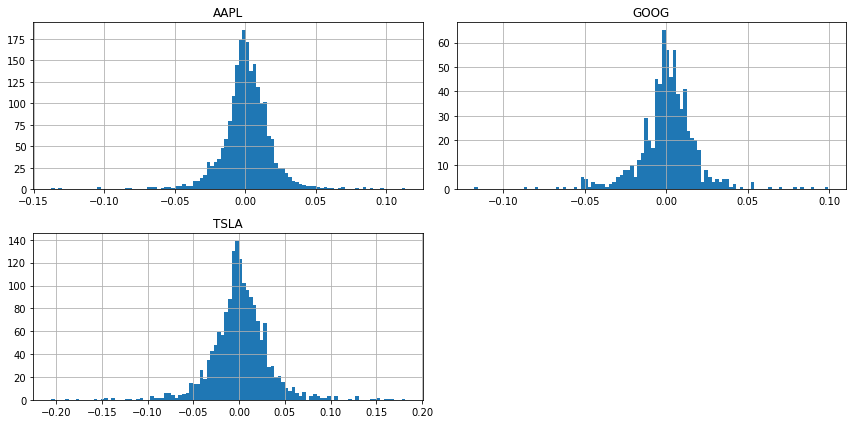

In [520]:
log_return.hist(bins=100, figsize=(12,6))
plt.tight_layout()

In [521]:
# Use describe function to calculate percentile, mean and STD
log_return.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AAPL,2085.0,0.000734,0.017666,-0.137708,-0.006991,0.000595,0.009648,0.113157
GOOG,720.0,0.000619,0.018590,-0.117667,-0.006292,0.000892,0.009381,0.099380
TSLA,1695.0,0.001003,0.032864,-0.205522,-0.014075,0.000753,0.016803,0.181445


In [522]:
#Calculate mean in terms of trading days
log_return.mean()*252

AAPL    0.184860
GOOG    0.155958
TSLA    0.252804
dtype: float64

In [523]:
# Computer pairwise covariance of columns
log_return.cov()*252

,AAPL,GOOG,TSLA
AAPL,0.078648,0.070916,0.049740
GOOG,0.070916,0.087091,0.070669
TSLA,0.049740,0.070669,0.272165


## Single Run for Random Allocation

In [524]:
# Set seed
np.random.seed(13)

# Stock Columns
print('Stocks')
print(stock_df.columns)
print('\n')

# Create Random Weights
print('Creating Random Weights')
weights = np.array(np.random.random(3))
weights = weights / np.sum(weights)
print(weights)
print('\n')

# Expected Return
print('Expected Portfolio Return')
expected_returns = np.sum(log_return.mean() * weights) *252
print(expected_returns)
print('\n')

# Expected Variance
print('Expected Volatility')
expected_variance = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))
print(expected_variance)
print('\n')

# Sharpe Ratio
sharpe_ratio = expected_returns/expected_variance
print('Sharpe Ratio')
print(sharpe_ratio)

Stocks
Index(['AAPL', 'GOOG', 'TSLA'], dtype='object')


Creating Random Weights
[0.42277415 0.12913202 0.44809383]


Expected Portfolio Return
0.21157314808446612


Expected Volatility
0.32392026555570086


Sharpe Ratio
0.6531642832581104


## Run Monte Carlo Simulation
Save Results in DataFrame

In [525]:
# Set the number of simulations
num_portfolios = 100

all_weights = np.zeros((num_portfolios,len(stock_df.columns)))
expected_returns_arr = np.zeros(num_portfolios)
expected_variance_arr = np.zeros(num_portfolios)
sharpe_arr = np.zeros(num_portfolios)

for ind in range(num_portfolios):

    # Create Random Weights
    weights = np.array(np.random.random(3))

    # Rebalance Weights
    weights = weights / np.sum(weights)
    
    # Save Weights
    all_weights[ind,:] = weights

    # Expected Return
    expected_returns_arr[ind] = np.sum((log_return.mean() * weights) *252)

    # Expected Variance
    expected_variance_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))

    # Sharpe Ratio
    sharpe_arr[ind] = expected_returns_arr[ind]/expected_variance_arr[ind]

In [526]:
# Determine the best sharpe ratio
sharpe_arr.max()

0.7117877109850996

In [527]:
# Determine the index of the max sharpe ratio
best_sharpe_index=sharpe_arr.argmax()

In [528]:
#Show weights of portfolio with the best sharpe ratio
all_weights[best_sharpe_index, :]

array([0.72410366, 0.0018429 , 0.27405344])

In [529]:
#Extract expected return of portfolio with the best sharpe ratio
best_return = expected_returns_arr[best_sharpe_index]
best_return

0.2034271219966603

In [530]:
#Extract expected variance of portfolio with the best sharpe ratio
best_variance = expected_variance_arr[best_sharpe_index]
best_variance

0.28579746300357073

## Plot Monte Carlo

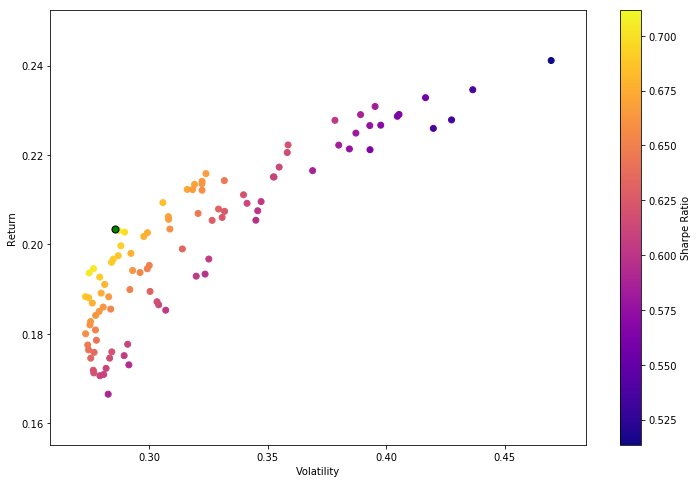

In [531]:
plt.figure(figsize=(12,8))
plt.scatter(expected_variance_arr, expected_returns_arr, c=sharpe_arr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Add green dot for max SR
plt.scatter(best_variance, best_return, c='green', s=50, edgecolors='black')

## Optimize Portfolio

In [532]:
def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array or return,volatility, sharpe ratio
    """
    weights = np.array(weights)
    ret = np.sum(log_return.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

In [533]:
def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

In [534]:
# Contraints
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

In [535]:
# By convention of minimize function it should be a function that returns zero for conditions
cons = ({'type':'eq','fun': check_sum})

In [536]:
# 0-1 bounds for each weight
bounds = ((0, 1), (0, 1), (0, 1))

In [537]:
# Initial Guess (equal distribution)
init_guess = [0.33,0.33,0.34]

In [540]:
# Sequential Least SQuares Programming (SLSQP).
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [541]:

get_ret_vol_sr(opt_results.x)

array([0.19985722, 0.27951986, 0.71500186])

## Efficient Frontier

In [542]:
# Our returns go from 0 to somewhere along 0.3
# Create a linspace number of points to calculate x on
frontier_y = np.linspace(0,0.3,100) # Change 100 to a lower number for slower computers!

In [543]:

def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1]

In [546]:
frontier_volatility = []

for possible_return in frontier_y:
    # function for return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

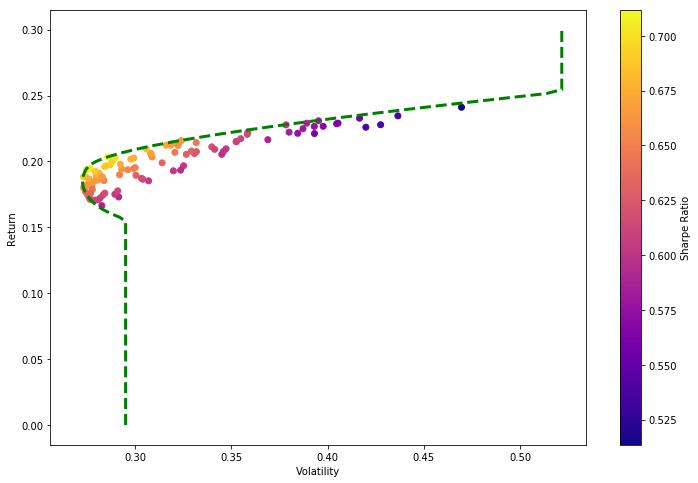

In [547]:
plt.figure(figsize=(12,8))
plt.scatter(expected_variance_arr,expected_returns_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')



# Add frontier line
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)

## Panel Dashboard

Combine all of the pie charts into a single dashboard view using Panel.

In [562]:
# Assign Content to dashboard

ticker_performance=pn.Column(returns_plot(portfolio4_df), pct_change_plot(portfolio_df_returns))
industry_analysis=pn.Row(industry_contribution_pie, industry_value_pie)
sector_analysis=pn.Row(sector_contribution_pie, sector_value_pie)
combo_analysis=pn.Column(industry_analysis, sector_analysis)
current_holdings=pn.Row(holdings_contribution_pie, holdings_value_pie)
# efficient_frontier=pn.panel(plt.plot)

efficient_frontier_pane=pn.pane.Plotly(plt.plot)


ValueError: Plotly pane does not support objects of type 'function'.

In [560]:
# Create the Tabs

dashboard=pn.Tabs(("Ticker Performance", ticker_performance),
                  ("Current Holdings", current_holdings),
                  ("Industry & Sector Analysis", combo_analysis),
                  ("Ticker Stats", stats_panel),
                  ("Efficient Frontier", efficient_frontier))


In [561]:
# Serve the Panel Dashboard

dashboard.servable()

Tabs
    [0] Column
        [0] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='Ticker', options=['AAPL', 'TSLA', 'GOOG'], value='AAPL', width=250)
                [1] VSpacer()
        [1] HoloViews(NdOverlay)
    [1] Row
        [0] Plotly(Figure)
        [1] Plotly(Figure)
    [2] Column
        [0] Row
            [0] Plotly(Figure)
            [1] Plotly(Figure)
        [1] Row
            [0] Plotly(Figure)
            [1] Plotly(Figure)
    [3] HTML(Styler)
    [4] Column
        [0] Column
            [0] Checkbox(name='scalex', value=True)
            [1] Checkbox(name='scaley', value=True)
        [1] Row
            [0] JSON(list, name='interactive83081')